In [ ]:
import os
import random
import time
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import zipfile

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from tqdm.notebook import tqdm

In [ ]:
def set_seed(seed=None):
    if seed is None:
        seed = int(time.time())  # Use current time as seed
    print(f"Using seed: {seed}")  # Optional: print to know what seed was used

    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed()  # No need to pass anything; it will randomize

Using seed: 1746290514


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [ ]:
# Download and extract datasets
def download_and_extract_dataset():
    # Download Monet dataset from Kaggle
    !pip install -q kaggle

    #upload kaggle.json
    from google.colab import files
    files.upload()
    !mkdir -p ~/.kaggle
    !cp kaggle.json ~/.kaggle/
    !chmod 600 ~/.kaggle/kaggle.json

    # Download the dataset (Kaggle GAN competition dataset with Monet paintings)
    !kaggle competitions download -c gan-getting-started

    # Extract the dataset
    with zipfile.ZipFile('gan-getting-started.zip', 'r') as zip_ref:
        zip_ref.extractall('data')

    print("Dataset downloaded and extracted.")

In [ ]:
class MonetDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        """
        Args:
            root_dir (string): Directory with Monet images
            transform (callable, optional): Optional transform to be applied on a sample
        """
        self.root_dir = root_dir
        self.transform = transform
        self.image_files = [f for f in os.listdir(root_dir) if f.endswith('.jpg') or f.endswith('.png')]

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.image_files[idx])
        image = Image.open(img_name).convert('RGB')

        if self.transform:
            image = self.transform(image)

        return image

In [ ]:
class PhotoDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        """
        Args:
            root_dir (string): Directory with photo images
            transform (callable, optional): Optional transform to be applied on a sample
        """
        self.root_dir = root_dir
        self.transform = transform
        self.image_files = [f for f in os.listdir(root_dir) if f.endswith('.jpg') or f.endswith('.png')]

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.image_files[idx])
        image = Image.open(img_name).convert('RGB')

        if self.transform:
            image = self.transform(image)

        return image

In [ ]:
class EnhancedTransform:
    def __init__(self, base_size=286, crop_size=256, brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1):
        """
        Enhanced data augmentation pipeline

        Args:
            base_size: Size to resize images to before random cropping
            crop_size: Size of random crop
            brightness: Brightness jitter factor
            contrast: Contrast jitter factor
            saturation: Saturation jitter factor
            hue: Hue jitter factor
        """
        self.transform = transforms.Compose([
            transforms.Resize(base_size),
            transforms.RandomCrop(crop_size),
            transforms.RandomHorizontalFlip(),
            transforms.RandomVerticalFlip(p=0.1),  # Add vertical flips
            transforms.RandomRotation(degrees=5),  # Small random rotations
            transforms.ColorJitter(brightness=brightness, contrast=contrast,
                                  saturation=saturation, hue=hue),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ])

    def __call__(self, img):
        return self.transform(img)

In [ ]:
# Residual Block for Generator
class ResidualBlock(nn.Module):
    def __init__(self, in_features):
        super(ResidualBlock, self).__init__()

        self.block = nn.Sequential(
            nn.ReflectionPad2d(1),
            nn.Conv2d(in_features, in_features, 3),
            nn.InstanceNorm2d(in_features),
            nn.ReLU(inplace=True),
            nn.ReflectionPad2d(1),
            nn.Conv2d(in_features, in_features, 3),
            nn.InstanceNorm2d(in_features)
        )

    def forward(self, x):
        return x + self.block(x)

In [ ]:
class Generator(nn.Module):
    def __init__(self, input_channels=3, output_channels=3, n_residual_blocks=9):
        super(Generator, self).__init__()

        # Initial convolution block
        model = [
            nn.ReflectionPad2d(3),
            nn.Conv2d(input_channels, 64, 7),
            nn.InstanceNorm2d(64),
            nn.ReLU(inplace=True)
        ]

        # Downsampling
        in_features = 64
        out_features = in_features * 2
        for _ in range(2):
            model += [
                nn.Conv2d(in_features, out_features, 3, stride=2, padding=1),
                nn.InstanceNorm2d(out_features),
                nn.ReLU(inplace=True)
            ]
            in_features = out_features
            out_features = in_features * 2

        # Residual blocks
        for _ in range(n_residual_blocks):
            model += [ResidualBlock(in_features)]

        # Upsampling
        out_features = in_features // 2
        for _ in range(2):
            model += [
                nn.ConvTranspose2d(in_features, out_features, 3, stride=2, padding=1, output_padding=1),
                nn.InstanceNorm2d(out_features),
                nn.ReLU(inplace=True)
            ]
            in_features = out_features
            out_features = in_features // 2

        # Output layer
        model += [
            nn.ReflectionPad2d(3),
            nn.Conv2d(64, output_channels, 7),
            nn.Tanh()
        ]

        self.model = nn.Sequential(*model)

    def forward(self, x):
        return self.model(x)

In [ ]:
# Discriminator Network
class Discriminator(nn.Module):
    def __init__(self, input_channels=3):
        super(Discriminator, self).__init__()

        # PatchGAN discriminator - 70x70 receptive field
        model = [
            nn.Conv2d(input_channels, 64, 4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True)
        ]

        model += [
            nn.Conv2d(64, 128, 4, stride=2, padding=1),
            nn.InstanceNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True)
        ]

        model += [
            nn.Conv2d(128, 256, 4, stride=2, padding=1),
            nn.InstanceNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True)
        ]

        model += [
            nn.Conv2d(256, 512, 4, padding=1),
            nn.InstanceNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True)
        ]

        # Output layer
        model += [nn.Conv2d(512, 1, 4, padding=1)]

        self.model = nn.Sequential(*model)

    def forward(self, x):
        return self.model(x)

In [ ]:
def add_instance_noise(x, std=0.1):
    """Add Gaussian noise to help stabilize GAN training"""
    return x + torch.randn_like(x) * std

In [ ]:
# Loss functions
class CycleGANLoss:
    def __init__(self, lambda_A=10.0, lambda_B=10.0, lambda_identity=0.05):
        self.criterionGAN = nn.MSELoss()
        self.criterionCycle = nn.L1Loss()
        self.criterionIdentity = nn.L1Loss()
        self.lambda_A = lambda_A
        self.lambda_B = lambda_B
        self.lambda_identity = lambda_identity

    def get_generator_loss(self, real_A, real_B, G_AB, G_BA, D_A, D_B):
        # Identity loss
        identity_A = G_BA(real_A)
        identity_B = G_AB(real_B)
        loss_identity_A = self.criterionIdentity(identity_A, real_A) * self.lambda_A * self.lambda_identity
        loss_identity_B = self.criterionIdentity(identity_B, real_B) * self.lambda_B * self.lambda_identity

        # GAN loss
        fake_B = G_AB(real_A)
        pred_fake_B = D_B(fake_B)
        target_real = torch.ones_like(pred_fake_B).to(device)
        loss_GAN_AB = self.criterionGAN(pred_fake_B, target_real)

        fake_A = G_BA(real_B)
        pred_fake_A = D_A(fake_A)
        loss_GAN_BA = self.criterionGAN(pred_fake_A, target_real)

        # Cycle loss
        recovered_A = G_BA(fake_B)
        loss_cycle_A = self.criterionCycle(recovered_A, real_A) * self.lambda_A

        recovered_B = G_AB(fake_A)
        loss_cycle_B = self.criterionCycle(recovered_B, real_B) * self.lambda_B

        # Total generator loss
        loss_G = loss_identity_A + loss_identity_B + loss_GAN_AB + loss_GAN_BA + loss_cycle_A + loss_cycle_B

        return loss_G, {
            'loss_G': loss_G.item(),
            'loss_identity_A': loss_identity_A.item(),
            'loss_identity_B': loss_identity_B.item(),
            'loss_GAN_AB': loss_GAN_AB.item(),
            'loss_GAN_BA': loss_GAN_BA.item(),
            'loss_cycle_A': loss_cycle_A.item(),
            'loss_cycle_B': loss_cycle_B.item()
        }

    def get_discriminator_loss(self, real_A, real_B, fake_A, fake_B, D_A, D_B):

        # Add noise to inputs
        noise_std = 0.1
        real_A = add_instance_noise(real_A, noise_std)
        real_B = add_instance_noise(real_B, noise_std)
        fake_A = add_instance_noise(fake_A.detach(), noise_std)
        fake_B = add_instance_noise(fake_B.detach(), noise_std)

        # Real loss
        pred_real_A = D_A(real_A)
        target_real = torch.ones_like(pred_real_A).to(device)
        loss_D_real_A = self.criterionGAN(pred_real_A, target_real)

        pred_real_B = D_B(real_B)
        loss_D_real_B = self.criterionGAN(pred_real_B, target_real)

        # Fake loss
        pred_fake_A = D_A(fake_A.detach())
        target_fake = torch.zeros_like(pred_fake_A).to(device)
        loss_D_fake_A = self.criterionGAN(pred_fake_A, target_fake)

        pred_fake_B = D_B(fake_B.detach())
        loss_D_fake_B = self.criterionGAN(pred_fake_B, target_fake)

        # Total discriminator loss
        loss_D_A = (loss_D_real_A + loss_D_fake_A) * 0.5
        loss_D_B = (loss_D_real_B + loss_D_fake_B) * 0.5

        return loss_D_A, loss_D_B, {
            'loss_D_A': loss_D_A.item(),
            'loss_D_B': loss_D_B.item(),
            'loss_D_real_A': loss_D_real_A.item(),
            'loss_D_fake_A': loss_D_fake_A.item(),
            'loss_D_real_B': loss_D_real_B.item(),
            'loss_D_fake_B': loss_D_fake_B.item()
        }

In [ ]:
# LR scheduler
class LRScheduler:
    def __init__(self, optimizers, num_epochs, start_decay=100, decay_epochs=100):
        self.optimizers = optimizers
        self.num_epochs = num_epochs
        self.start_decay = start_decay
        self.decay_epochs = decay_epochs
        self.initial_lr = {}

        for optimizer in optimizers:
            self.initial_lr[optimizer] = optimizer.param_groups[0]['lr']

    def step(self, epoch):
        for optimizer in self.optimizers:
            if epoch >= self.start_decay:
                # Linear decay to zero over decay_epochs
                lrd = self.initial_lr[optimizer] / self.decay_epochs
                new_lr = self.initial_lr[optimizer] - lrd * (epoch - self.start_decay + 1)
                new_lr = max(0.0, new_lr)

                for param_group in optimizer.param_groups:
                    param_group['lr'] = new_lr

In [ ]:
def train_cycle_gan(monet_dataloader, photo_dataloader, num_epochs=300, resume_from_epoch=0, checkpoint_dir='checkpoints'):
    """
    Simplified train_cycle_gan function without early stopping

    Args:
        monet_dataloader: DataLoader for Monet images
        photo_dataloader: DataLoader for photo images
        num_epochs: Number of epochs to train
        resume_from_epoch: Epoch to resume training from
        checkpoint_dir: Directory to save checkpoints
    """
    # Create checkpoint directory if it doesn't exist
    os.makedirs(checkpoint_dir, exist_ok=True)

    # Initialize networks
    G_AB = Generator().to(device)  # Photo to Monet
    G_BA = Generator().to(device)  # Monet to Photo
    D_A = Discriminator().to(device)  # Discriminator for Monet domain
    D_B = Discriminator().to(device)  # Discriminator for Photo domain

    # Initialize optimizers
    optimizer_G = optim.Adam(list(G_AB.parameters()) + list(G_BA.parameters()), lr=0.0001, betas=(0.5, 0.999))
    optimizer_D_A = optim.Adam(D_A.parameters(), lr=0.0001, betas=(0.5, 0.999))
    optimizer_D_B = optim.Adam(D_B.parameters(), lr=0.0001, betas=(0.5, 0.999))

    # Initialize LR scheduler
    scheduler = LRScheduler([optimizer_G, optimizer_D_A, optimizer_D_B], num_epochs)

    # Initialize loss calculator
    cycle_loss = CycleGANLoss(lambda_A=10.0, lambda_B=10.0, lambda_identity=0.1)

    # Load checkpoint if resuming training
    start_epoch = 0
    if resume_from_epoch > 0:
        checkpoint_path = os.path.join(checkpoint_dir, f'checkpoint_epoch_{resume_from_epoch}.pth')
        if os.path.exists(checkpoint_path):
            checkpoint = torch.load(checkpoint_path, map_location=device)
            G_AB.load_state_dict(checkpoint['G_AB'])
            G_BA.load_state_dict(checkpoint['G_BA'])
            D_A.load_state_dict(checkpoint['D_A'])
            D_B.load_state_dict(checkpoint['D_B'])
            optimizer_G.load_state_dict(checkpoint['optimizer_G'])
            optimizer_D_A.load_state_dict(checkpoint['optimizer_D_A'])
            optimizer_D_B.load_state_dict(checkpoint['optimizer_D_B'])
            start_epoch = resume_from_epoch
            print(f"Resuming training from epoch {resume_from_epoch}")
        else:
            print(f"No checkpoint found at {checkpoint_path}, starting from scratch")

    # Training loop
    for epoch in range(start_epoch, start_epoch + num_epochs):
        # Update learning rates
        scheduler.step(epoch)

        # Initialize metrics
        metrics = {'loss_G': 0, 'loss_D_A': 0, 'loss_D_B': 0,
                  'loss_cycle_A': 0, 'loss_cycle_B': 0,
                  'loss_identity_A': 0, 'loss_identity_B': 0}

        # Create iterators for data loaders
        monet_iter = iter(monet_dataloader)
        photo_iter = iter(photo_dataloader)

        # Determine number of iterations per epoch
        num_iters = min(len(monet_dataloader), len(photo_dataloader))

        # Progress bar
        pbar = tqdm(range(num_iters), desc=f"Epoch {epoch+1}/{start_epoch + num_epochs}")

        for i in pbar:
            # Get batch of images
            try:
                real_A = next(monet_iter).to(device)  # Monet paintings
            except StopIteration:
                monet_iter = iter(monet_dataloader)
                real_A = next(monet_iter).to(device)

            try:
                real_B = next(photo_iter).to(device)  # Photos
            except StopIteration:
                photo_iter = iter(photo_dataloader)
                real_B = next(photo_iter).to(device)

            # Generate fake images
            fake_B = G_AB(real_A)  # Monet to Photo
            fake_A = G_BA(real_B)  # Photo to Monet

            # Train generators
            optimizer_G.zero_grad()
            loss_G, g_metrics = cycle_loss.get_generator_loss(real_A, real_B, G_AB, G_BA, D_A, D_B)
            loss_G.backward()
            torch.nn.utils.clip_grad_norm_(list(G_AB.parameters()) + list(G_BA.parameters()), max_norm=10)
            optimizer_G.step()

            # Train discriminators
            optimizer_D_A.zero_grad()
            optimizer_D_B.zero_grad()
            loss_D_A, loss_D_B, d_metrics = cycle_loss.get_discriminator_loss(real_A, real_B, fake_A, fake_B, D_A, D_B)
            loss_D_A.backward()
            loss_D_B.backward()
            optimizer_D_A.step()
            optimizer_D_B.step()

            # Update metrics
            for k, v in g_metrics.items():
                if k in metrics:
                    metrics[k] += v
            for k, v in d_metrics.items():
                if k in metrics:
                    metrics[k] += v

            # Update progress bar
            display_metrics = {k: v/num_iters for k, v in metrics.items()}
            pbar.set_postfix(display_metrics)

        # Save checkpoint and visualize samples every 10 epochs
        if (epoch + 1) % 10 == 0 or epoch == start_epoch:
            checkpoint = {
                'epoch': epoch + 1,
                'G_AB': G_AB.state_dict(),
                'G_BA': G_BA.state_dict(),
                'D_A': D_A.state_dict(),
                'D_B': D_B.state_dict(),
                'optimizer_G': optimizer_G.state_dict(),
                'optimizer_D_A': optimizer_D_A.state_dict(),
                'optimizer_D_B': optimizer_D_B.state_dict(),
                'metrics': display_metrics
            }

            checkpoint_path = os.path.join(checkpoint_dir, f'checkpoint_epoch_{epoch+1}.pth')
            torch.save(checkpoint, checkpoint_path)

            # Save individual models every 10 epochs
            torch.save(G_AB.state_dict(), os.path.join(checkpoint_dir, f'G_AB_epoch_{epoch+1}.pth'))
            torch.save(G_BA.state_dict(), os.path.join(checkpoint_dir, f'G_BA_epoch_{epoch+1}.pth'))

            print(f"Saved checkpoint at epoch {epoch+1}")

            # Visualize samples every 10 epochs
            visualize_samples(G_AB, G_BA, monet_dataloader, photo_dataloader, epoch)

    print(f"Training finished after {num_epochs} epochs.")
    return G_AB, G_BA, D_A, D_B

In [ ]:
# Visualize sample transformations
def visualize_samples(G_AB, G_BA, monet_dataloader, photo_dataloader, epoch):
    G_AB.eval()
    G_BA.eval()

    with torch.no_grad():
        # Get sample images - adapt to work with any batch size
        # Collect up to 4 images from each domain
        monet_samples = []
        photo_samples = []

        # Get Monet samples
        for batch in monet_dataloader:
            monet_samples.append(batch)
            if len(monet_samples) >= 4:
                break

        # Get Photo samples
        for batch in photo_dataloader:
            photo_samples.append(batch)
            if len(photo_samples) >= 4:
                break

        # Concatenate batches and take up to 4 images
        real_A = torch.cat(monet_samples, dim=0)[:4].to(device)
        real_B = torch.cat(photo_samples, dim=0)[:4].to(device)

        # Adjust the number of images to visualize based on what's available
        num_samples = min(len(real_A), len(real_B))

        # Generate fake images
        fake_B = G_AB(real_A)  # Monet to Photo
        fake_A = G_BA(real_B)  # Photo to Monet

        # Generate recovered images
        rec_A = G_BA(fake_B)  # Monet -> Photo -> Monet
        rec_B = G_AB(fake_A)  # Photo -> Monet -> Photo

        # Create figure - adjust based on available samples
        fig, axs = plt.subplots(num_samples, 5, figsize=(15, 3*num_samples))

        # Handle case when there's only one row
        if num_samples == 1:
            axs = axs.reshape(1, -1)

        # Helper function to denormalize and show images
        def show_tensor_image(tensor, ax, title):
            image = tensor.detach().cpu().numpy().transpose(1, 2, 0)
            # Denormalize: [-1, 1] -> [0, 1]
            image = (image + 1) / 2
            image = np.clip(image, 0, 1)
            ax.imshow(image)
            ax.set_title(title)
            ax.axis('off')

        # Row titles
        row_titles = ['Real Monet', 'Monet to Photo', 'Recovered Monet',
                     'Real Photo', 'Photo to Monet', 'Recovered Photo']

        # Show images
        for i in range(num_samples):
            show_tensor_image(real_A[i], axs[i, 0], 'Real Monet')
            show_tensor_image(fake_B[i], axs[i, 1], 'Monet to Photo')
            show_tensor_image(rec_A[i], axs[i, 2], 'Recovered Monet')
            show_tensor_image(real_B[i], axs[i, 3], 'Real Photo')
            show_tensor_image(fake_A[i], axs[i, 4], 'Photo to Monet')

        plt.tight_layout()
        plt.savefig(f'samples_epoch_{epoch+1}.png')
        plt.close()

    G_AB.train()
    G_BA.train()

In [ ]:
def main(resume_epoch=0):
    # Download and extract the dataset
    download_and_extract_dataset()

    # Create more aggressive data augmentation
    transform = EnhancedTransform(
        base_size=300,  # Slightly larger for more crop variety
        crop_size=256,
        brightness=0.3,  # Stronger color jittering
        contrast=0.3,
        saturation=0.3,
        hue=0.1
    )

    # Create datasets
    monet_dataset = MonetDataset(root_dir='data/monet_jpg', transform=transform)
    photo_dataset = PhotoDataset(root_dir='data/photo_jpg', transform=transform)

    # Create dataloaders
    monet_dataloader = DataLoader(monet_dataset, batch_size=1, shuffle=True, num_workers=4)
    photo_dataloader = DataLoader(photo_dataset, batch_size=1, shuffle=True, num_workers=4)

    print(f"Monet dataset size: {len(monet_dataset)}")
    print(f"Photo dataset size: {len(photo_dataset)}")

    # Create checkpoint directory
    checkpoint_dir = 'checkpoints'
    os.makedirs(checkpoint_dir, exist_ok=True)

   # Train the CycleGAN with more epochs
    G_AB, G_BA, D_A, D_B = train_cycle_gan(
        monet_dataloader,
        photo_dataloader,
        num_epochs=300,
        resume_from_epoch=resume_epoch,
        checkpoint_dir='checkpoints'
    )

    # Save final models
    torch.save(G_AB.state_dict(), os.path.join(checkpoint_dir, 'G_AB_final.pth'))
    torch.save(G_BA.state_dict(), os.path.join(checkpoint_dir, 'G_BA_final.pth'))
    torch.save(D_A.state_dict(), os.path.join(checkpoint_dir, 'D_A_final.pth'))
    torch.save(D_B.state_dict(), os.path.join(checkpoint_dir, 'D_B_final.pth'))

    print("Training completed and models saved.")

In [ ]:
# Function to apply Monet style to a single image
def apply_monet_style(image_path, model_path='checkpoints/G_BA_final.pth'):
    """
    Apply Monet style to a single image

    Args:
        image_path: Path to the input image
        model_path: Path to the saved model (can be a checkpoint or final model)

    Returns:
        styled_image: The styled image as a numpy array
    """
    # Load the model
    model = Generator().to(device)

    # Handle different types of saved models
    if model_path.endswith('.pth'):
        # Check if it's a checkpoint file or just the model state dict
        try:
            checkpoint = torch.load(model_path, map_location=device)

            # If it's a checkpoint dictionary (has 'G_BA' key)
            if isinstance(checkpoint, dict) and 'G_BA' in checkpoint:
                model.load_state_dict(checkpoint['G_BA'])
                print(f"Loaded model from checkpoint: {model_path}")
            else:
                # If it's just the model state dict
                model.load_state_dict(checkpoint)
                print(f"Loaded model state dict: {model_path}")
        except Exception as e:
            print(f"Error loading model: {e}")
            return None

    model.eval()

    # Define transform
    transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(256),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

    # Load and transform image
    image = Image.open(image_path).convert('RGB')
    image_tensor = transform(image).unsqueeze(0).to(device)

    # Apply style transfer
    with torch.no_grad():
        styled_image = model(image_tensor)

    # Convert tensor to image
    styled_image = styled_image.detach().cpu().squeeze(0).numpy()
    styled_image = styled_image.transpose(1, 2, 0)
    styled_image = (styled_image + 1) / 2  # Denormalize: [-1, 1] -> [0, 1]
    styled_image = np.clip(styled_image, 0, 1)

    # Display original and styled images
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
    ax1.imshow(np.array(image))
    ax1.set_title('Original Image')
    ax1.axis('off')

    ax2.imshow(styled_image)
    ax2.set_title('Monet Style')
    ax2.axis('off')

    plt.tight_layout()
    plt.show()

    # Save the result
    output_path = f"styled_{os.path.basename(image_path)}"
    plt.figure(figsize=(8, 8))
    plt.imshow(styled_image)
    plt.axis('off')
    plt.savefig(output_path, bbox_inches='tight', pad_inches=0)
    plt.close()
    print(f"Saved styled image to {output_path}")

    return styled_image

Loaded model state dict: checkpoints/G_BA_epoch_300.pth


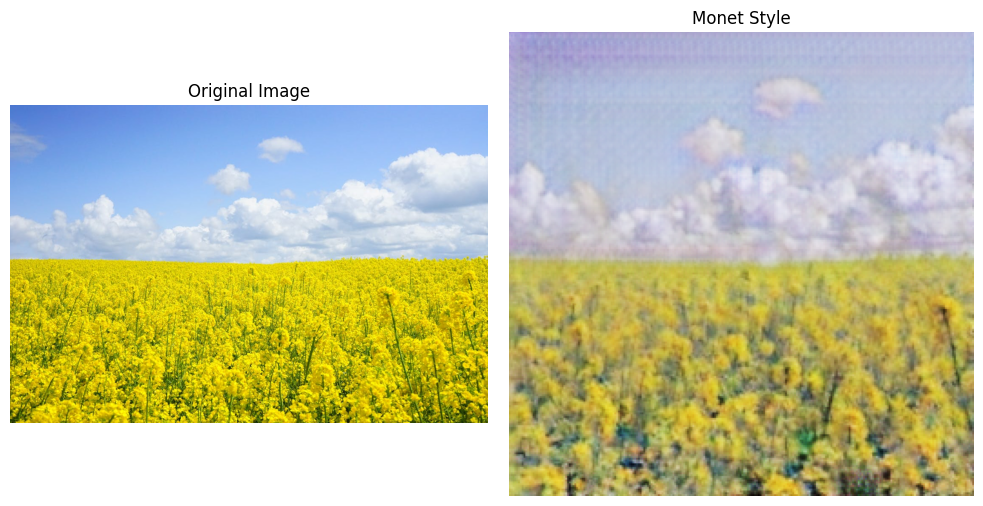

Saved styled image to styled_1.jpeg


In [ ]:
styled_image = apply_monet_style(
    image_path="",
    model_path=""
)

In [ ]:
if __name__ == "__main__":
    import argparse
    import sys

    # Create parser
    parser = argparse.ArgumentParser(description="Train or resume CycleGAN for Monet style transfer")
    parser.add_argument('--resume', type=int, default=0, help='Resume training from epoch')
    parser.add_argument('--style', type=str, default=None, help='Path to image to style transfer')
    parser.add_argument('--model', type=str, default='checkpoints/G_BA_final.pth',
                       help='Path to model for style transfer')

    # Filter out Colab's injected arguments
    args, unknown = parser.parse_known_args()

    if args.style:
        apply_monet_style(args.style, model_path=args.model)
    else:
        main(resume_epoch=args.resume)

KeyboardInterrupt: 